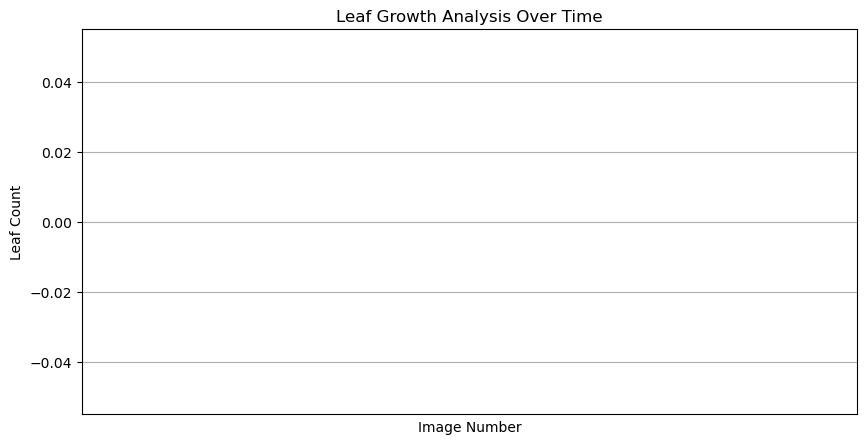

In [106]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def count_leaves(image_path, display_results=True, min_contour_area=60):
    """
    Enhanced leaf counter with better leaf separation and integrated contour splitting
    """
    # Load image
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"Error loading image: {image_path}")
        return 0, None
    
    # Resize and enhance contrast
    image = cv2.resize(image, (600, 600))
    result_image = image.copy()
    
    # CLAHE contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    # Color segmentation with edge detection
    hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([95, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    # Add edge information to mask
    edges = cv2.Canny(mask, 50, 150)
    mask = cv2.bitwise_or(mask, edges)
    
    # Improved morphological processing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    # Watershed segmentation with adjusted parameters
    sure_bg = cv2.dilate(mask, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.3*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    # Marker creation
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    
    # Apply watershed
    markers = cv2.watershed(enhanced, markers)
    
    # Process watershed results
    valid_contours = []
    for label in np.unique(markers):
        if label > 1:
            label_mask = np.zeros_like(mask)
            label_mask[markers == label] = 255
            contours = cv2.findContours(label_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
            
            for cnt in contours:
                area = cv2.contourArea(cnt)
                if area > min_contour_area:
                    # Split large contours (integrated split_contour functionality)
                    if area > 2*min_contour_area:
                        # Try to split using convexity defects
                        hull = cv2.convexHull(cnt, returnPoints=False)
                        split_points = []
                        
                        try:
                            defects = cv2.convexityDefects(cnt, hull)
                            if defects is not None:
                                for i in range(defects.shape[0]):
                                    s,e,f,d = defects[i,0]
                                    if d > 0.02 * cv2.arcLength(cnt, True):  # Minimum defect depth
                                        split_points.append(f)
                                
                                if len(split_points) >= 1:
                                    # Split the contour at the first significant defect point
                                    split_contours = [cnt[:split_points[0]], cnt[split_points[0]:]]
                                    valid_contours.extend([c for c in split_contours if cv2.contourArea(c) > min_contour_area])
                                else:
                                    valid_contours.append(cnt)
                            else:
                                valid_contours.append(cnt)
                        except:
                            valid_contours.append(cnt)  # If split fails, keep original contour
                    else:
                        valid_contours.append(cnt)
    
    # Strict shape validation
    final_contours = []
    for cnt in valid_contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
            
        circularity = 4 * np.pi * area / (perimeter**2)
        x,y,w,h = cv2.boundingRect(cnt)
        aspect_ratio = w / max(h, 1)
        hull = cv2.convexHull(cnt)
        solidity = area / cv2.contourArea(hull) if cv2.contourArea(hull) > 0 else 0
        
        if (0.2 < circularity < 0.7 and 
            0.3 < aspect_ratio < 4.0 and 
            solidity > 0.5):
            final_contours.append(cnt)
    
    # Draw results
    for i, cnt in enumerate(final_contours):
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(result_image, (x,y), (x+w,y+h), (0,255,0), 2)
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"]/M["m00"])
            cy = int(M["m01"]/M["m00"])
            cv2.putText(result_image, str(i+1), (cx,cy), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
    
    cv2.putText(result_image, f'Leaves: {len(final_contours)}', (20,50), 
               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    
    if display_results:
        show_results(image, mask, markers, result_image)
    
    return len(final_contours), result_image

def show_results(original, mask, markers, result):
    """Visualization helper"""
    plt.figure(figsize=(15,10))
    
    plt.subplot(2,2,1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(2,2,2)
    plt.title("Processing Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2,2,3)
    plt.title("Segmentation Markers")
    plt.imshow(markers, cmap='jet')
    plt.axis('off')
    
    plt.subplot(2,2,4)
    plt.title("Final Result")
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))


if __name__ == "__main__":
    # For a single image
    """
    image_path = "images/leaf count/new folder/f.jpg"  # Replace with your image path
    count_leaves(image_path)
    """
    image_paths = []
    input_path = Path('images/leaf count/new folder')
    for image_file in input_path.rglob('*.jpg'):
        image_paths.append(image_file)
    
    leaf_counts = []
    for image_path in image_paths:
        leaf_count, _ = count_leaves(image_path, display_results=True)
        leaf_counts.append(leaf_count)
    
    # Plotting leaf count growth over time
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(leaf_counts) + 1), leaf_counts, marker='o', linestyle='-', color='g')
    plt.title('Leaf Growth Analysis Over Time')
    plt.xlabel('Image Number')
    plt.ylabel('Leaf Count')
    plt.xticks(range(1, len(leaf_counts) + 1))
    plt.grid()
    plt.show()